In [1]:
import numpy
import pandas as pd
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
import os
import cv2 as cv
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.nn as nn
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable

# Define the data and label

In [2]:
def getlabel(dir):
    labels=[]
    for name in os.listdir(dir):
        if os.path.splitext(name)[1] == '.JPG':
            fname=os.path.splitext(name)[0]
            fname=fname.split('-')[1]
            labels.append(fname)
    labels = list(map(float, labels))
    labels = torch.tensor(labels)
    # Normalize labels
    #min = torch.min(labels)
    #max = torch.max(labels)
    #labels = (labels - min) / (max - min)
    #labels = labels/300
    labels = labels.type(torch.FloatTensor)
    labels = labels.unsqueeze(1)
    return labels

def generate_dataset(dir):
    """
    set_label should be 'torch.tensor([1])' if two-catogory and positive sample
    """
    train_data = []
    for file_name in os.listdir(dir):
        if file_name != "Thumbs.db":
            img_dir = os.path.join(dir, file_name)
            img = cv.imread(img_dir)
            #img = cv.resize(img, (769, 432))   # /5 resize img
            #img_gray = cv.cvtColor(img,cv.COLOR_RGB2GRAY)
            pimg = Image.fromarray(img)
            train_data.append(pimg)
    return train_data

In [3]:
traindir= './train/'
validdir = './valid/'
train_data0 = generate_dataset(traindir)
train_label0=getlabel(traindir)
valid_data0 = generate_dataset(validdir)
valid_label0 = getlabel(validdir)


In [4]:
train_label0

tensor([[  0.0000],
        [ 20.0000],
        [ 28.0000],
        [ 35.0000],
        [ 37.0000],
        [ 39.0000],
        [ 42.0000],
        [ 48.0000],
        [ 51.0000],
        [ 62.0000],
        [ 72.0000],
        [ 75.0000],
        [ 81.0000],
        [ 97.0000],
        [ 96.0000],
        [105.0000],
        [111.0000],
        [118.0000],
        [124.0000],
        [135.0000],
        [140.0000],
        [146.0000],
        [154.0000],
        [165.0000],
        [161.0000],
        [158.0000],
        [154.0000],
        [150.0000],
        [146.0000],
        [143.0000],
        [138.0000],
        [135.0000],
        [133.0000],
        [130.0000],
        [127.0000],
        [124.0000],
        [122.0000],
        [119.0000],
        [116.0000],
        [110.0000],
        [107.0000],
        [103.0000],
        [ 96.0000],
        [ 94.0000],
        [ 92.0000],
        [ 90.0000],
        [ 86.0000],
        [ 84.0000],
        [ 81.0000],
        [ 80.5000],


# 重写dataset类

In [5]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None, target_transform=None):
        self.transform = transform
        self.target_transform = target_transform
        imgs = []
        for i in range(len(labels)):
            # print(type(data[i]))    # <class 'PIL.Image.Image'>
            im_tensor = transform(data[i])#.to(torch.device("cpu"))
            imgs.append((im_tensor, labels[i]))
        self.imgs = imgs                         # DataLoader通过getitem读取图片数据
    def __getitem__(self, index):
        fn, label = self.imgs[index]
        return fn, label
    def __len__(self):
        return len(self.imgs)
    

# 用MyDataset构建数据集

In [31]:

transform = transforms.Compose([
    transforms.Resize(600),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
"""""
transform = transforms.Compose(
    [transforms.Grayscale(num_output_channels=1), #彩色图像转灰度图像num_output_channels默认1
    transforms.ToTensor(),  # range [0, 255] -> [0.0,1.0]   
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
"""""

# 也可以再定义train_transform加入一些数据增强 
train_data = MyDataset(train_data0, train_label0, transform=transform)
valid_data = MyDataset(valid_data0, valid_label0, transform=transform)
train_loader = DataLoader(dataset=train_data, batch_size=5, shuffle=True)
valid_loader = DataLoader(dataset=valid_data, batch_size=1, shuffle=True)
dataiter=iter(train_loader)
images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([5, 3, 600, 600])
torch.Size([5, 1])


In [7]:
train_label0.data.numpy()

array([[  0. ],
       [ 20. ],
       [ 28. ],
       [ 35. ],
       [ 37. ],
       [ 39. ],
       [ 42. ],
       [ 48. ],
       [ 51. ],
       [ 62. ],
       [ 72. ],
       [ 75. ],
       [ 81. ],
       [ 97. ],
       [ 96. ],
       [105. ],
       [111. ],
       [118. ],
       [124. ],
       [135. ],
       [140. ],
       [146. ],
       [154. ],
       [165. ],
       [161. ],
       [158. ],
       [154. ],
       [150. ],
       [146. ],
       [143. ],
       [138. ],
       [135. ],
       [133. ],
       [130. ],
       [127. ],
       [124. ],
       [122. ],
       [119. ],
       [116. ],
       [110. ],
       [107. ],
       [103. ],
       [ 96. ],
       [ 94. ],
       [ 92. ],
       [ 90. ],
       [ 86. ],
       [ 84. ],
       [ 81. ],
       [ 80.5],
       [ 79. ],
       [ 76. ],
       [ 74. ],
       [ 72. ],
       [ 68. ],
       [ 65. ],
       [ 63. ],
       [ 61. ],
       [ 59.5],
       [ 58. ],
       [ 56.5],
       [ 55. ],
       [

# 定义网络

In [8]:
# todo Bottleneck
class Bottleneck(nn.Module):
    """
    __init__
        in_channel：残差块输入通道数
        out_channel：残差块输出通道数
        stride：卷积步长
        downsample：在_make_layer函数中赋值，用于控制shortcut图片下采样 H/2 W/2
    """
    expansion = 4   # 残差块第3个卷积层的通道膨胀倍率
    def __init__(self, in_channel, out_channel, stride=1, downsample=None):
        super(Bottleneck, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=1, stride=1, bias=False)   # H,W不变。C: in_channel -> out_channel
        self.bn1 = nn.BatchNorm2d(num_features=out_channel)
        self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=stride, bias=False, padding=1)  # H/2，W/2。C不变
        self.bn2 = nn.BatchNorm2d(num_features=out_channel)
        self.conv3 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel*self.expansion, kernel_size=1, stride=1, bias=False)   # H,W不变。C: out_channel -> 4*out_channel
        self.bn3 = nn.BatchNorm2d(num_features=out_channel*self.expansion)
        self.relu = nn.ReLU(inplace=True)

        self.downsample = downsample

    def forward(self, x):
        identity = x    # 将原始输入暂存为shortcut的输出
        if self.downsample is not None:
            identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel(见ResNet中的downsample实现)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out += identity     # 残差连接
        out = self.relu(out)

        return out

In [9]:
def forward(self, x):
    identity = x    # 将原始输入暂存为shortcut的输出
    if self.downsample is not None:
        identity = self.downsample(x)   # 如果需要下采样，那么shortcut后:H/2，W/2。C: out_channel -> 4*out_channel

In [10]:
class ResNet(nn.Module):
    """
    __init__
        block: 堆叠的基本模块
        block_num: 基本模块堆叠个数,是一个list,对于resnet50=[3,4,6,3]
        num_classes: 全连接之后的分类特征维度

    _make_layer
        block: 堆叠的基本模块
        channel: 每个stage中堆叠模块的第一个卷积的卷积核个数，对resnet50分别是:64,128,256,512
        block_num: 当期stage堆叠block个数
        stride: 默认卷积步长
    """
    def __init__(self, block, block_num, num_classes):
        super(ResNet, self).__init__()
        self.in_channel = 64    # conv1的输出维度

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=self.in_channel, kernel_size=7, stride=2, padding=3, bias=False)     # H/2,W/2。C:3->64
        self.bn1 = nn.BatchNorm2d(self.in_channel)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)     # H/2,W/2。C不变
        self.layer1 = self._make_layer(block=block, channel=64, block_num=block_num[0], stride=1)   # H,W不变。downsample控制的shortcut，out_channel=64x4=256
        self.layer2 = self._make_layer(block=block, channel=128, block_num=block_num[1], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=128x4=512
        self.layer3 = self._make_layer(block=block, channel=256, block_num=block_num[2], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=256x4=1024
        self.layer4 = self._make_layer(block=block, channel=512, block_num=block_num[3], stride=2)  # H/2, W/2。downsample控制的shortcut，out_channel=512x4=2048

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))  # 将每张特征图大小->(1,1)，则经过池化后的输出维度=通道数
        self.fc1 = nn.Linear(in_features=512*block.expansion, out_features=1024) #in=2048,out=1024
        self.fc2 = nn.Linear(in_features=1024, out_features=512) #in=1024, out=512
        self.fc3 = nn.Linear(in_features=512, out_features=num_classes) #in=512, out=1

        for m in self.modules():    # 权重初始化
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def _make_layer(self, block, channel, block_num, stride=1):
        downsample = None   # 用于控制shorcut路的
        if stride != 1 or self.in_channel != channel*block.expansion:   # 对resnet50：conv2中特征图尺寸H,W不需要下采样/2，但是通道数x4，因此shortcut通道数也需要x4。对其余conv3,4,5，既要特征图尺寸H,W/2，又要shortcut维度x4
            downsample = nn.Sequential(
                nn.Conv2d(in_channels=self.in_channel, out_channels=channel*block.expansion, kernel_size=1, stride=stride, bias=False), # out_channels决定输出通道数x4，stride决定特征图尺寸H,W/2
                nn.BatchNorm2d(num_features=channel*block.expansion))

        layers = []  # 每一个convi_x的结构保存在一个layers列表中，i={2,3,4,5}
        layers.append(block(in_channel=self.in_channel, out_channel=channel, downsample=downsample, stride=stride)) # 定义convi_x中的第一个残差块，只有第一个需要设置downsample和stride
        self.in_channel = channel*block.expansion   # 在下一次调用_make_layer函数的时候，self.in_channel已经x4

        for _ in range(1, block_num):  # 通过循环堆叠其余残差块(堆叠了剩余的block_num-1个)
            layers.append(block(in_channel=self.in_channel, out_channel=channel))

        return nn.Sequential(*layers)   # '*'的作用是将list转换为非关键字参数传入

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

## Res18

In [11]:
class ResidualBlock(nn.Module):
    def __init__(self,channels):
        super(ResidualBlock,self).__init__()
        self.channels = channels
        self.conv1 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.conv2 = nn.Conv2d(channels,channels,kernel_size=3,padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self,x):
        y = self.conv1(x)
        y = F.relu(self.bn1(y))
        y = self.conv2(y)
        y = F.relu(self.bn2(y))
        return F.relu(x+y)

In [12]:
class Net(torch.nn.Module):
    # Net类的初始化函数
    def __init__(self):
        # 继承父类的初始化函数
        super(Net, self).__init__()
        # 网络的隐藏层创建，名称可以随便起
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=10, stride=2)
        self.bn1 = nn.BatchNorm2d(3)
        self.conv2 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=10, stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(6)
        self.conv3 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=1)
        self.bn3 = nn.BatchNorm2d(12)
        #residual
        self.rblock1 = ResidualBlock(12)
        self.conv4 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1)
        self.bn4 = nn.BatchNorm2d(24)
        self.rblock2 = ResidualBlock(24)
        self.conv5 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=2, stride=1)
        self.bn5 = nn.BatchNorm2d(48)
        self.rblock3 = ResidualBlock(48)
        self.conv6 = nn.Conv2d(in_channels=48, out_channels=96, kernel_size=2, stride=1)
        self.bn6 = nn.BatchNorm2d(96)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(96*8*8, 3072)
        self.fc2 = nn.Linear(3072,500)
        self.fc3 = torch.nn.Linear(500, 100)
        # 输出层(预测层)创建，接收来自隐含层的数据
        self.predict_layer = torch.nn.Linear(100, 1)

    # 网络的前向传播函数，构造计算图
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))     #(2400-10)/2+1=1196
        x = self.pool(x)                        #1196/2=598
        x = F.relu(self.bn2(self.conv2(x)))     #(598+2-10)/2+1=296
        x = self.pool(x)                        #296/2=148
        x = F.relu(self.bn3(self.conv3(x)))     #(148-5)/1+1=144
        x = self.pool(x)                        #144/2=72
        x = self.rblock1(x)
        x = F.relu(self.bn4(self.conv4(x)))     #(72-3)/1+1=70
        x = self.pool(x)                        #70/2=35
        x = self.rblock2(x)
        x = F.relu(self.bn5(self.conv5(x)))     #(35-2)/1+1=34
        x = self.pool(x)                        #34/2=17
        x = self.rblock3(x)
        x = F.relu(self.bn6(self.conv6(x)))     #17-2+1=16
        x = self.pool(x)                        #16/2=8
        x = x.view(-1, 96*8*8)
        # 用relu函数处理隐含层输出的结果并传给输出层
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        predict_result = self.predict_layer(x)
        return predict_result

In [13]:
def testAccuracy():
    
    net.eval()
    accuracy = 0.0
    total = 0.0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    with torch.no_grad():
        for data in valid_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # run the model on the test set to predict labels
            outputs = net(images)
            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    
    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    return(accuracy)

def train(num_epochs,device):
    import time
    start_time = time.process_time()
    best_accuracy = 0.0

    # Define your execution device
    #device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")

    predata=[]
    labeldata=[]
    mseloss=[]
    trainnum=[]
    # Convert model parameters and buffers to CPU or Cuda
    net.to(device)
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        running_acc = 0.0

        for i, (images, labels) in enumerate(train_loader, 0):
            #images, labels = dataiter.next()
            # 输入数据进行预测
            # get the inputs
            images = Variable(images.to(device))
            labels = Variable(labels.to(device))
            prediction = net(images)
            #print(prediction,labels)
            #print('Prediction data is:',prediction.data.cpu().numpy()[0])
            #print('label data is: ',labels.data.cpu().numpy())
            # 计算预测值与真值误差，注意参数顺序问题
            # 第一个参数为预测值，第二个为真值
            loss = loss_func(prediction, labels)
            # 开始优化步骤
            # 每次开始优化前将梯度置为0
            optimizer.zero_grad()
            # 误差反向传播
            loss.backward()
            # 按照最小loss优化参数
            optimizer.step()
            running_loss += loss.item()

            if (i+1) % 10 == 0:
                # print every 1000 (twice per epoch)
                #print(f"epoch #{epoch+1} Iteration #{i+1} loss: {loss_value}")
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 10))
                mseloss.append(running_loss/10)
                trainnum.append((i+1)*(epoch+1))
                # zero the loss
                running_loss = 0.0
            predata.append(prediction.data.cpu().numpy()[0])
            labeldata.append(labels.data.cpu().numpy()[0])

        #accuracy = testAccuracy()
        #print('For epoch', epoch+1,'the test accuracy over the whole test set is %d %%' % (accuracy))


    print('Finished Training')
    
    plt.figure()
    plt.plot()
    plt.grid(True)
    plt.ylim(0,205)
    plt.xlim(0,205)
    plt.plot(train_label0.data.numpy(), train_label0.data.numpy(), c='Red', lw='3')
    plt.scatter(predata,labeldata)
    plt.text(0.5, 0, 'Loss=%.4f' % loss.data.cpu().numpy(), fontdict={'size': 20, 'color':  'red'})

    
    plt.figure()
    plt.legend()
    plt.grid(True)
    plt.ylim(0,5)
    plt.ylabel("Mean Squared Error")
    plt.xlabel("train times")
    plt.plot(trainnum,mseloss)


    end_time = time.process_time()
    print("Use time:", end_time-start_time)


In [14]:
Vdataiter=iter(valid_loader)
vimg, vlabels = Vdataiter.next()
print(vimg.shape)
print(vlabels.shape)
print(vlabels)

torch.Size([1, 3, 1200, 1200])
torch.Size([1, 1])
tensor([[68.]])


## 预测结果

In [15]:
def predict(model, device,dataloder):
    Vdataiter=iter(dataloder)
    vimg, vlabels = Vdataiter.next()
    model.to(device)
    with torch.no_grad():
        vimg=vimg.to(device)
        out = model(vimg)
        #_, pre = torch.max(out.data, 1)
        return out, vlabels

# 定义模型

In [16]:
# 输入输出的数据维度，这里都是1维
INPUT_FEATURE_DIM = 5000
# 隐含层中神经元的个数
#NEURON_NUM = 500
#OUTPUT_FEATURE_DIM = 1
# 学习率，越大学的越快，但也容易造成不稳定，准确率上下波动的情况
LEARNING_RATE = 0.00025

# 定义模型
#net = Net()
net = ResNet(block=Bottleneck, block_num=[3,4,6,3],num_classes=1)
print(net)
# 训练网络
# 这里也可以使用其它的优化方法
optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
# 定义一个误差计算方法
loss_func = torch.nn.MSELoss() # 定义交叉熵损失函数 交叉熵损失函数是用来衡量两个概率分布之间的距离的#nn.MSELoss()
# Define the loss function with Classification Cross-Entropy loss and an optimizer with Adam optimizer

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# 主函数

[1,    10] loss: 2565.626
[1,    20] loss: 1741.487
[1,    30] loss: 1646.686
[1,    40] loss: 1636.268
[1,    50] loss: 1706.974
[1,    60] loss: 1173.466
[1,    70] loss: 1384.435
[1,    80] loss: 1503.685
[1,    90] loss: 2009.502
[1,   100] loss: 1699.816
[1,   110] loss: 1429.881
[2,    10] loss: 1091.511
[2,    20] loss: 917.603
[2,    30] loss: 943.556
[2,    40] loss: 950.315
[2,    50] loss: 1002.421
[2,    60] loss: 1527.119
[2,    70] loss: 954.376
[2,    80] loss: 1073.350
[2,    90] loss: 1114.071
[2,   100] loss: 1294.699
[2,   110] loss: 935.039
[3,    10] loss: 872.204
[3,    20] loss: 621.290
[3,    30] loss: 755.999
[3,    40] loss: 670.113
[3,    50] loss: 501.228
[3,    60] loss: 989.437
[3,    70] loss: 736.672
[3,    80] loss: 738.082
[3,    90] loss: 709.097
[3,   100] loss: 931.608
[3,   110] loss: 979.834
[4,    10] loss: 741.242
[4,    20] loss: 530.149
[4,    30] loss: 538.522
[4,    40] loss: 542.062
[4,    50] loss: 517.991
[4,    60] loss: 465.767
[4,    7

No handles with labels found to put in legend.


Use time: 1875.4375
Finished Training


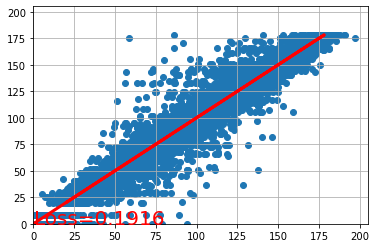

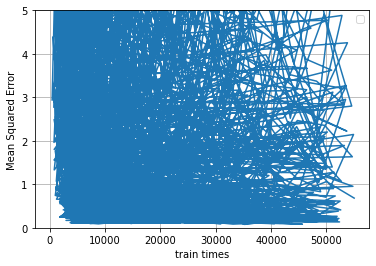

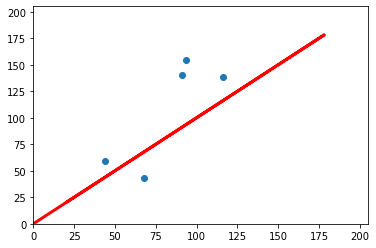

In [22]:
 # Vdataiter=iter(valid_loader)
# vimg, vlabels = Vdataiter.next()
# print(vimg.shape)
# print(vlabels.shape)
# print(vlabels)
if __name__ == "__main__":

    torch.cuda.empty_cache()
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = torch.device("cpu")
    # Let's build our model
    train(500,device)
    print('Finished Training')
    #Epochごとのlossの保存
    torch.save(net, 'preloadnet1.pt')

    # Test which classes performed well
    testAccuracy()
    
    # Let's load the model we just created and test the accuracy per label
    # model = net()
    # path = "myFirstModel.pth"
    # model.load_state_dict(torch.load(path))

    plt.figure()
    predata, labedata = predict(net, device,valid_loader)
    plt.xlim(0,205)
    plt.ylim(0,205)
    plt.scatter(predata.data.cpu().numpy(),labedata.data.cpu().numpy())
    plt.plot(train_label0.data.numpy(), train_label0.data.numpy(), c='Red', lw='3')


# Get the predecdata

In [34]:
x=[]
y=[]
np.array(x)
np.array(y)
# net=torch.load('')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
for i, (images, labels) in enumerate(valid_loader, 0):
    #images, labels = dataiter.next()
    # 输入数据进行预测
    # get the inputs
    images = Variable(images.to(device))
    labels = Variable(labels.to(device))
    predata, labedata = predict(net, "cpu",valid_loader)
    loss=loss_func(predata, labedata)
    loss += loss.item()
    x=np.append(x,[i[0] for i in labedata.data.cpu().numpy()])
    y=np.append(y,np.array([i[0] for i in predata.data.cpu().numpy()]))
    preloss=loss/(i+1)

x0=x
y0=y

[  0.           1.13567839   2.27135678   3.40703518   4.54271357
   5.67839196   6.81407035   7.94974874   9.08542714  10.22110553
  11.35678392  12.49246231  13.6281407   14.7638191   15.89949749
  17.03517588  18.17085427  19.30653266  20.44221106  21.57788945
  22.71356784  23.84924623  24.98492462  26.12060302  27.25628141
  28.3919598   29.52763819  30.66331658  31.79899497  32.93467337
  34.07035176  35.20603015  36.34170854  37.47738693  38.61306533
  39.74874372  40.88442211  42.0201005   43.15577889  44.29145729
  45.42713568  46.56281407  47.69849246  48.83417085  49.96984925
  51.10552764  52.24120603  53.37688442  54.51256281  55.64824121
  56.7839196   57.91959799  59.05527638  60.19095477  61.32663317
  62.46231156  63.59798995  64.73366834  65.86934673  67.00502513
  68.14070352  69.27638191  70.4120603   71.54773869  72.68341709
  73.81909548  74.95477387  76.09045226  77.22613065  78.36180905
  79.49748744  80.63316583  81.76884422  82.90452261  84.04020101
  85.17587

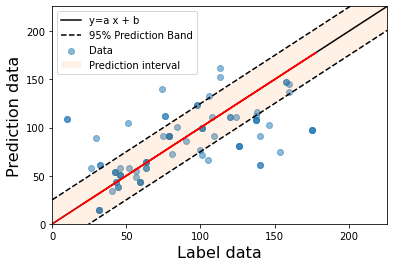

In [35]:

x=np.linspace(0,226,200)
y=np.linspace(0,226,200)

from scipy.optimize import curve_fit
from scipy import stats
import uncertainties.unumpy as unp
import uncertainties as unc

plt.figure()

plt.xlim(0,226)
plt.ylim(0,226)
y_err1=1.1*train_label0.data.cpu().numpy()
y_err2=0.9*train_label0.data.cpu().numpy()
n = len(y)

print(x)


def f(x, a, b):
    return np.multiply(a, x) + b
popt, pcov = curve_fit(f, x, y)

# retrieve parameter values
a = popt[0]
b = popt[1]
print('Optimal Values')
print('a: ' + str(a))
print('b: ' + str(b))

# compute r^2
r2 = 1.0-(sum((y0-f(x0,a,b))**2.0)/((n-1.0)*np.var(y,ddof=1)))
print('R^2: ' + str(r2))
print('testdataNum:' + str(i+1))
print('preloss:' + str(preloss))

# plot data

plt.scatter(x0,y0,alpha=0.5, label='Data')

# calculate regression confidence interval
px=np.linspace(0,226,200)
py=a*px+b
nom = unp.nominal_values(py)
std = unp.std_devs(py)

def predband(x, xd, yd, p, func, conf=0.95):
    # x = requested points
    # xd = x data
    # yd = y data
    # p = parameters
    # func = function name
    alpha = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - alpha / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

#plt.fill_between(df['temperature'], predictions['obs_ci_lower'], predictions['obs_ci_upper'], alpha=.1, label='Prediction interval')
# prediction band (95% confidence)

# plot the regression
plt.plot(px, nom, c='black', label='y=a x + b')

# # uncertainty lines (95% confidence)
# plt.plot(px, nom - 1.96 * std, c='orange',\
#          label='95% Confidence Region')
# plt.plot(px, nom + 1.96 * std, c='orange')

lpb, upb = predband(px, x0, y0, popt, f, conf=0.95)

lpb=[x+25 for x in px]
upb=[x-25 for x in px]

plt.plot(px, lpb, 'k--',label='95% Prediction Band')
plt.plot(px, upb, 'k--')
plt.fill_between(px,lpb,upb, alpha=.1, label='Prediction interval')
plt.plot(train_label0.data.numpy(), train_label0.data.numpy(), c='Red')

plt.legend(loc='best')
plt.xlabel('Label data',fontsize=16)
plt.ylabel('Prediction data',fontsize=16)
text='$R^2$: {:.2f}'.format(r2)
#plt.text(180,20,text)
plt.savefig('predictpreload.png', dpi=1200)
plt.show()

# bolt detec

In [301]:
#bolt preload detect

bdetecpath='./bdetec/'
bdetec_data0 = generate_dataset(bdetecpath)
bdetec_label0 = getlabel(bdetecpath)
bdetec_data = MyDataset(bdetec_data0, bdetec_label0, transform=transform)
bdetec_loader = DataLoader(dataset=bdetec_data, batch_size=1, shuffle=True)

#datasetのクラス指定
dataset_class=['person', 'traffic light', 'train', 'traffic sign', 'rider', 'car', 'bike', 'motor', 'truck', 'bolt']
#表示したいラベルの色の指定
#注意！！一番最初は背景クラスを示すので(0,0,0)にする
colors = ((0,0,0),(255,0,0),(0,255,0),(0,0,255),(100,100,100),(50,50,50),(255,255,0),(255,0,255),(0,255,255),(100,100,0),(0,100,100))

#ハイパーパラメータの指定
epochs=3
batch_size=2
scale=3684#画像のスケール設定(縦の大きさを入力)


#使用デバイスの確認
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

import cv2
import glob
import matplotlib.pyplot as plt

data_class=dataset_class
data_class.insert(0, "__background__")
classes = tuple(data_class)

cuda


In [ ]:
def predict(model, device,dataloder):
    Vdataiter=iter(dataloder)
    vimg, vlabels = Vdataiter.next()
    model.to(device)
    with torch.no_grad():
        vimg=vimg.to(device)
        out = model(vimg)
        #_, pre = torch.max(out.data, 1)
        return out, vlabels

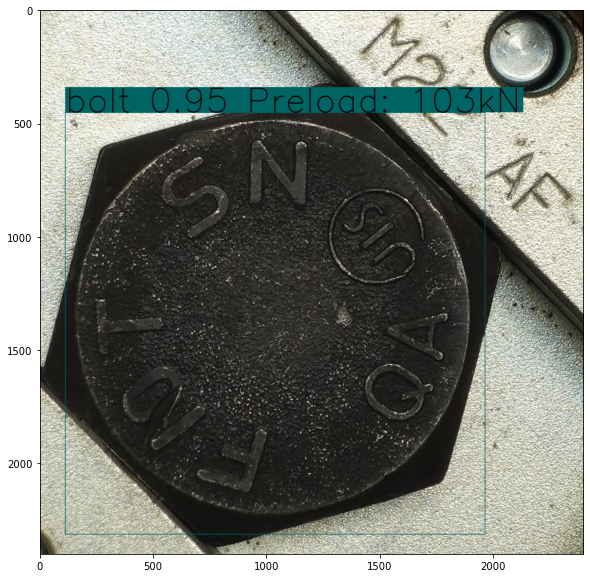

In [311]:
test_path="./bdetec/"
model=torch.load('bolt_detec.pt')
model.to(device)
model.eval()

for imgfile in sorted(glob.glob(test_path+'/*')):

    img = cv2.imread(imgfile)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image_tensor = transforms.functional.to_tensor(img)

    with torch.no_grad():
        prediction = model([image_tensor.to(device)])

    for i,box in enumerate(prediction[0]['boxes']):
        score = prediction[0]['scores'][i].cpu().numpy()
        prebt, labebt = predict(net, 'cpu',bdetec_loader)
        if score > 0.5:
            score = round(float(score),2)
            cat = prediction[0]['labels'][i].cpu().numpy()
            txt = '{} {} Preload: {}kN'.format(classes[int(cat)], str(score),int(prebt))
            font = cv2.FONT_HERSHEY_SIMPLEX
            cat_size = cv2.getTextSize(txt, font, 5, 10)[0]
            c = colors[int(cat)]
            box=box.cpu().numpy().astype('int')
            cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), c , 2)
            cv2.rectangle(img,(box[0], box[1] - cat_size[1] - 2),(box[0] + cat_size[0], box[1] - 2), c, -1)
            cv2.putText(img, txt, (box[0], box[1] - 2), font, 5, (0, 0, 0), thickness=3, lineType=cv2.LINE_AA)


    plt.figure(figsize=(15,10))
    plt.imshow(img)
plt.show()